## Libraries

In [ ]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
from PIL import Image
import torch
import lpips
import time
import os

In [ ]:
# resize to 256x256 and normalize to [-1, 1]
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),  # converts to [0,1]
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # converts to [-1, 1]
])

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, root_A, root_B, transform=None):
        self.transform = transform
        self.files_A = sorted([os.path.join(root_A, f) for f in os.listdir(root_A) if f.endswith(".jpg")])
        self.files_B = sorted([os.path.join(root_B, f) for f in os.listdir(root_B) if f.endswith(".jpg")])

    def __len__(self):
        return min(len(self.files_A), len(self.files_B))

    def __getitem__(self, idx):
        img_A = Image.open(self.files_A[idx]).convert("RGB")
        img_B = Image.open(self.files_B[idx]).convert("RGB")

        if self.transform:
            img_A = self.transform(img_A)
            img_B = self.transform(img_B)

        return {"A": img_A, "B": img_B}

In [ ]:
dataset = ImageDataset("/kaggle/input/monet2photo/trainA", "/kaggle/input/monet2photo/trainB", transform=transform)

In [ ]:
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [5]:
for i, batch in enumerate(dataloader):
    print(batch["A"].shape, batch["B"].shape)
    break

torch.Size([1, 3, 256, 256]) torch.Size([1, 3, 256, 256])


## Generator

In [ ]:
class ResnetBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1), # padding to preserve spatial size
            nn.Conv2d(dim, dim, 3), # first conv layer
            nn.InstanceNorm2d(dim), # normalization 
            nn.ReLU(inplace=True), # activation with ReLU
            nn.ReflectionPad2d(1), # padding
            nn.Conv2d(dim, dim, 3), # second conv layer
            nn.InstanceNorm2d(dim), # normalization
        )

    def forward(self, x):
        return x + self.block(x)

# full ResNet generator --part 1
class ResnetGenerator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, n_blocks=9):
        super().__init__()

        # encoder (initial conv block)
        model = [
            nn.ReflectionPad2d(3), # padding
            nn.Conv2d(in_channels, 64, 7), # large kernel in order to capture more features
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),
        ]
        # encoder --part 2: downsampling layers
        in_features = 64
        for _ in range(2):
            out_features = in_features * 2
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features

        # transformation layers (ResNet blocks)
        for _ in range(n_blocks): # n_block = 9
            model += [ResnetBlock(in_features)]

        # decoder: upsampling layers
        for _ in range(2):
            out_features = in_features // 2
            model += [
                nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features

        # output layer
        model += [
            nn.ReflectionPad2d(3), # padding
            nn.Conv2d(64, out_channels, 7), # out_channels = 3
            nn.Tanh() # for normalization the output to [-1, 1]
        ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

## Discriminator

In [ ]:
# PatchGAN Discriminator
class PatchDiscriminator(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()

        # helper function to define a conv layer
        def block(in_feat, out_feat, norm=True):
            layers = [nn.Conv2d(in_feat, out_feat, 4, stride=2, padding=1)]
            if norm:
                layers.append(nn.InstanceNorm2d(out_feat)) # apply normalization if needed
            layers.append(nn.LeakyReLU(0.2, inplace=True)) # ReLU activation
            return layers

        # the discriminator model as a series of conv layers
        self.model = nn.Sequential(
            *block(in_channels, 64, norm=False), # first layer without normalization (as mentionned on the original paper)
            *block(64, 128), 
            *block(128, 256),
            *block(256, 512),
            nn.Conv2d(512, 1, 4, padding=1) # final output layer with single channel output (real or fake)
        )

    def forward(self, x):
        return self.model(x)

## Loss functions

### Adversarial Loss

In [ ]:
adv_criterion = nn.MSELoss()

### Cycle Consistency Loss

In [ ]:
cycle_criterion = nn.L1Loss()

### Identity loss

In [ ]:
identity_criterion = nn.L1Loss()

## Training loop

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
G_A2B = ResnetGenerator().to(device)
G_B2A = ResnetGenerator().to(device)
D_A = PatchDiscriminator().to(device)
D_B = PatchDiscriminator().to(device)

In [ ]:
optimizer_G = optim.Adam(
    list(G_A2B.parameters()) + list(G_B2A.parameters()), 
    lr=0.0002, 
    betas=(0.5, 0.999)
)

optimizer_D_A = optim.Adam(D_A.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_B = optim.Adam(D_B.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [ ]:
lambda_identity = 5.0
lambda_cycle = 10.0
num_epochs = 50

In [ ]:
G_losses = []
D_A_losses = []
D_B_losses = []
epoch_times = []

In [ ]:
for epoch in range(num_epochs):
    epoch_start_time = time.time() # start time of epoch
    total_loss_G = 0
    total_loss_D_A = 0
    total_loss_D_B = 0
    total_batches = len(dataloader)

    for batch_idx, batch in enumerate(dataloader):
        batch_start_time = time.time()  # start time of batch

        real_A = batch["A"].to(device)
        real_B = batch["B"].to(device)

        # train generators
        optimizer_G.zero_grad()

        # identity loss
        same_B = G_A2B(real_B)
        same_A = G_B2A(real_A)
        loss_id_A = identity_criterion(same_A, real_A) * lambda_identity
        loss_id_B = identity_criterion(same_B, real_B) * lambda_identity

        # adversarial loss
        fake_B = G_A2B(real_A)
        pred_fake_B = D_B(fake_B)
        loss_GAN_A2B = adv_criterion(pred_fake_B, torch.ones_like(pred_fake_B))

        fake_A = G_B2A(real_B)
        pred_fake_A = D_A(fake_A)
        loss_GAN_B2A = adv_criterion(pred_fake_A, torch.ones_like(pred_fake_A))

        # cycle consistency loss
        rec_A = G_B2A(fake_B)
        rec_B = G_A2B(fake_A)
        loss_cycle_A = cycle_criterion(rec_A, real_A) * lambda_cycle
        loss_cycle_B = cycle_criterion(rec_B, real_B) * lambda_cycle

        # total generator loss
        loss_G = loss_id_A + loss_id_B + loss_GAN_A2B + loss_GAN_B2A + loss_cycle_A + loss_cycle_B
        loss_G.backward()
        optimizer_G.step()

        # train discriminators
        optimizer_D_A.zero_grad()
        pred_real_A = D_A(real_A)
        pred_fake_A = D_A(fake_A.detach())
        loss_D_real_A = adv_criterion(pred_real_A, torch.ones_like(pred_real_A))
        loss_D_fake_A = adv_criterion(pred_fake_A, torch.zeros_like(pred_fake_A))
        loss_D_A = (loss_D_real_A + loss_D_fake_A) * 0.5
        loss_D_A.backward()
        optimizer_D_A.step()

        optimizer_D_B.zero_grad()
        pred_real_B = D_B(real_B)
        pred_fake_B = D_B(fake_B.detach())
        loss_D_real_B = adv_criterion(pred_real_B, torch.ones_like(pred_real_B))
        loss_D_fake_B = adv_criterion(pred_fake_B, torch.zeros_like(pred_fake_B))
        loss_D_B = (loss_D_real_B + loss_D_fake_B) * 0.5
        loss_D_B.backward()
        optimizer_D_B.step()

        # accumulate losses
        total_loss_G += loss_G.item()
        total_loss_D_A += loss_D_A.item()
        total_loss_D_B += loss_D_B.item()

        # time running per batch
        batch_time = time.time() - batch_start_time
        remaining_batches = total_batches - (batch_idx + 1)
        estimated_time_left = batch_time * remaining_batches
        print(f"Batch {batch_idx+1}/{total_batches} completed in {batch_time:.2f} seconds. Estimated time left: {estimated_time_left/60:.2f} minutes.", end='\r')

    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time
    G_losses.append(total_loss_G / total_batches)
    D_A_losses.append(total_loss_D_A / total_batches)
    D_B_losses.append(total_loss_D_B / total_batches)
    epoch_times.append(epoch_duration / 60)

    print(f"\nEpoch [{epoch+1}/{num_epochs}] completed in {epoch_duration/60:.2f} minutes.")
    print(f"  Generator Loss: {total_loss_G/total_batches:.4f}")
    print(f"  Discriminator A Loss: {total_loss_D_A/total_batches:.4f}")
    print(f"  Discriminator B Loss: {total_loss_D_B/total_batches:.4f}")

Batch 1072/1072 completed in 0.31 seconds. Estimated time left: 0.00 minutes.
Epoch [1/50] completed in 5.88 minutes.
  Generator Loss: 9.4155
  Discriminator A Loss: 0.2321
  Discriminator B Loss: 0.2305
Batch 1072/1072 completed in 0.31 seconds. Estimated time left: 0.00 minutes.
Epoch [2/50] completed in 5.71 minutes.
  Generator Loss: 8.2792
  Discriminator A Loss: 0.2062
  Discriminator B Loss: 0.2025
Batch 1072/1072 completed in 0.31 seconds. Estimated time left: 0.00 minutes.
Epoch [3/50] completed in 5.71 minutes.
  Generator Loss: 7.8202
  Discriminator A Loss: 0.2010
  Discriminator B Loss: 0.1926
Batch 1072/1072 completed in 0.31 seconds. Estimated time left: 0.00 minutes.
Epoch [4/50] completed in 5.71 minutes.
  Generator Loss: 7.4974
  Discriminator A Loss: 0.1956
  Discriminator B Loss: 0.1877
Batch 1072/1072 completed in 0.31 seconds. Estimated time left: 0.00 minutes.
Epoch [5/50] completed in 5.71 minutes.
  Generator Loss: 7.2597
  Discriminator A Loss: 0.1933
  Disc

### Save models

In [17]:
torch.save(G_A2B.state_dict(), "G_A2B.pth")
torch.save(G_B2A.state_dict(), "G_B2A.pth")
torch.save(D_A.state_dict(), "D_A.pth")
torch.save(D_B.state_dict(), "D_B.pth")

## Evaluation

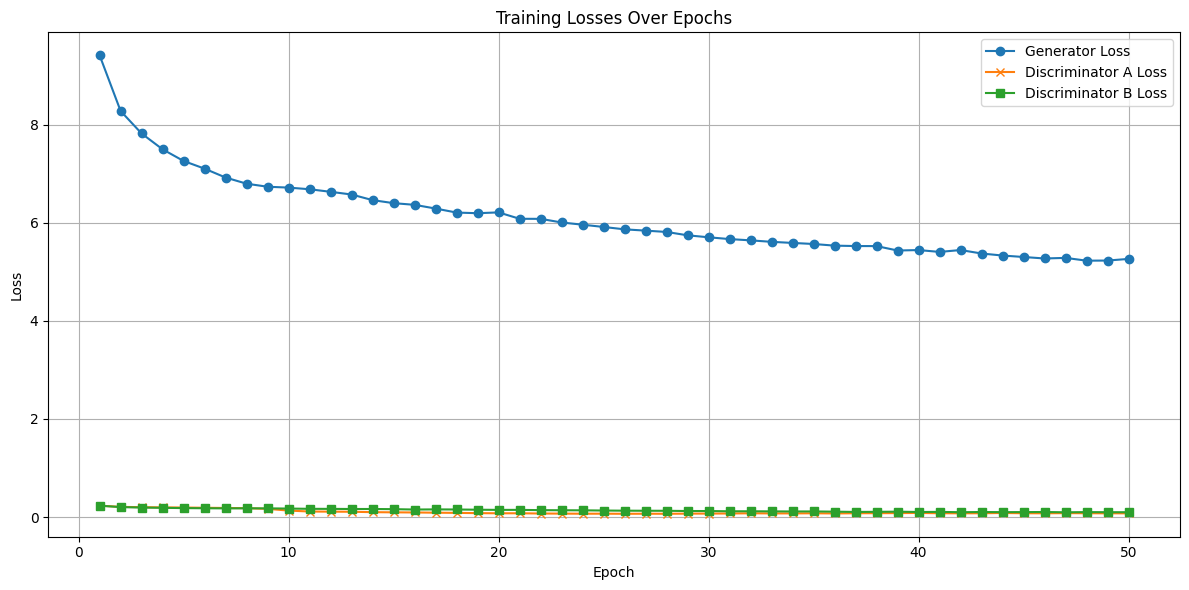

In [ ]:
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 6))

# generator loss
plt.plot(epochs, G_losses, label='Generator Loss', marker='o')

# discriminator losses
plt.plot(epochs, D_A_losses, label='Discriminator A Loss', marker='x')
plt.plot(epochs, D_B_losses, label='Discriminator B Loss', marker='s')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

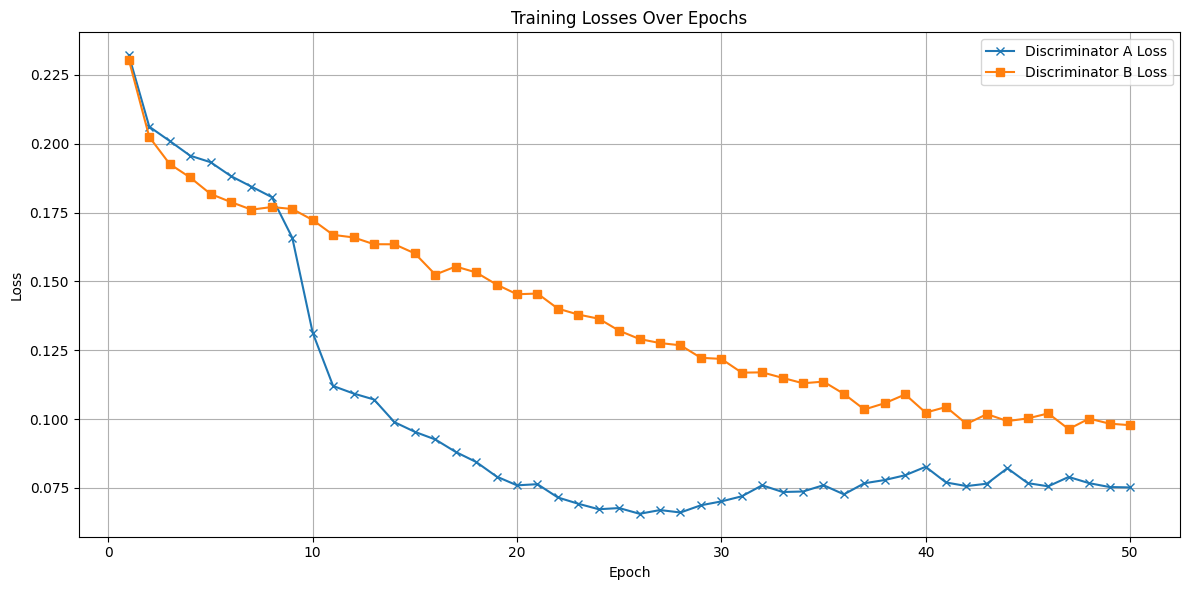

In [ ]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 6))

# discriminator losses
plt.plot(epochs, D_A_losses, label='Discriminator A Loss', marker='x')
plt.plot(epochs, D_B_losses, label='Discriminator B Loss', marker='s')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

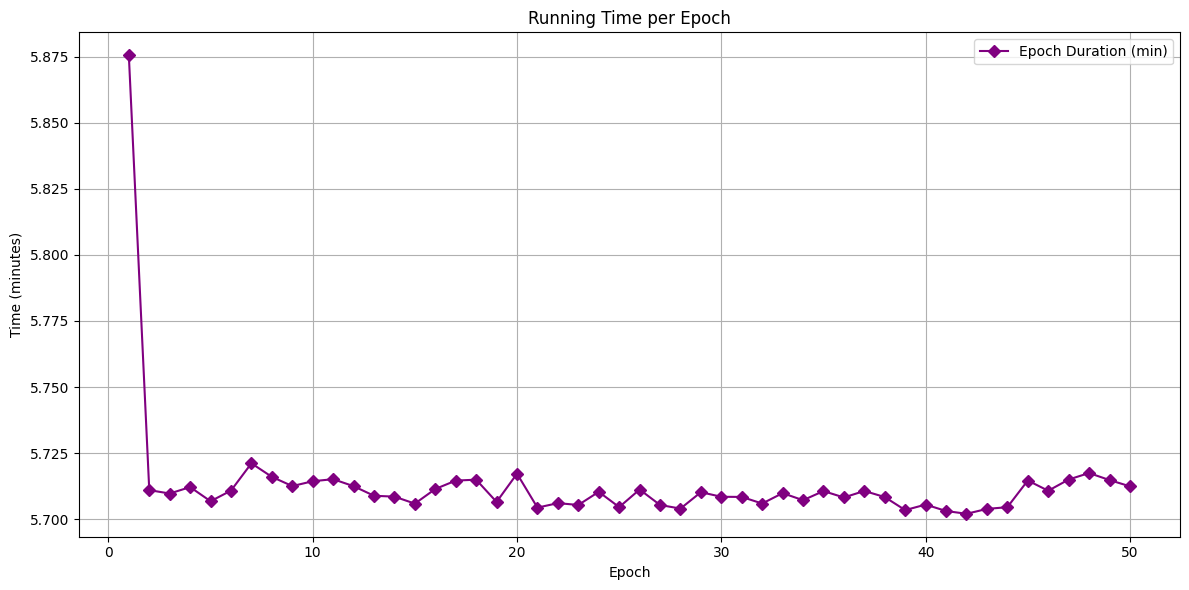

In [19]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, epoch_times, label='Epoch Duration (min)', marker='D', color='purple')
plt.xlabel('Epoch')
plt.ylabel('Time (minutes)')
plt.title('Running Time per Epoch')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Testing phase

In [21]:
test_dataset = ImageDataset("/kaggle/input/monet2photo/testA", "/kaggle/input/monet2photo/testB", transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

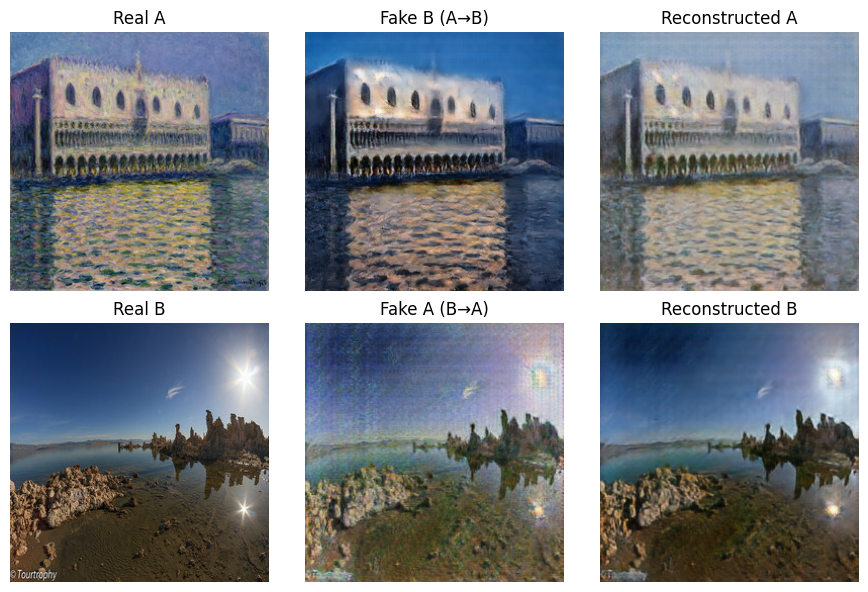

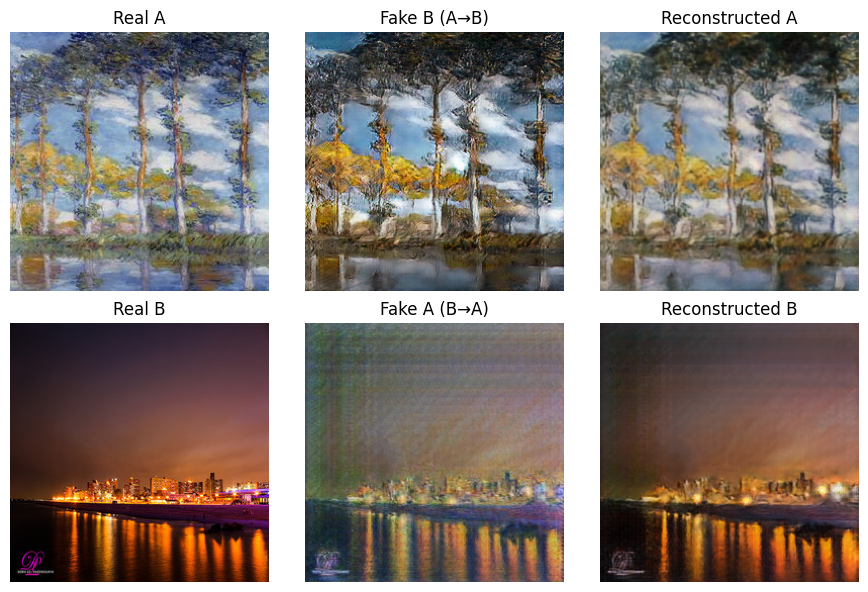

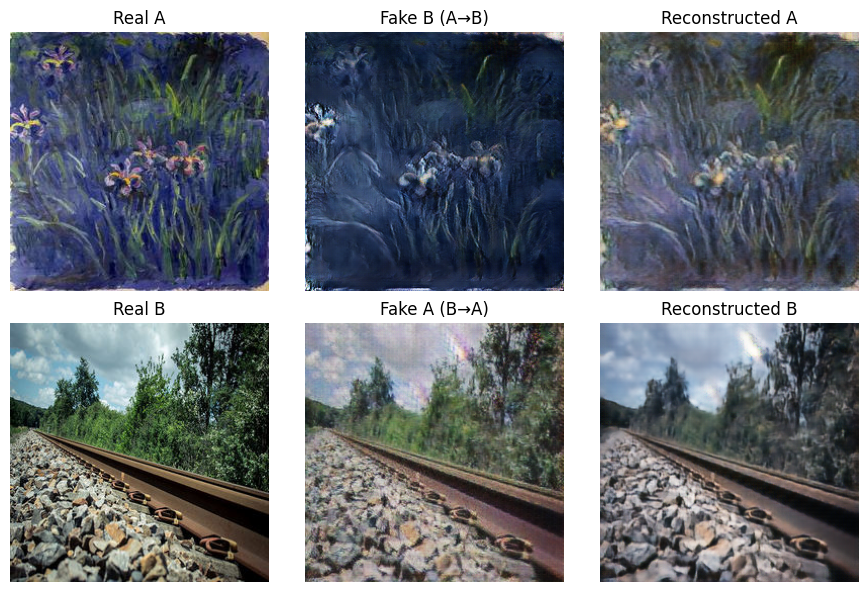

In [ ]:
def imshow(tensor, title):
    image = tensor.cpu().clone().detach()
    image = image.squeeze(0)
    image = (image + 1) / 2 
    np_img = image.numpy().transpose((1, 2, 0))
    plt.imshow(np_img)
    plt.title(title)
    plt.axis('off')

with torch.no_grad():
    for i, batch in enumerate(test_dataloader):
        if i >= 3: break  # show 3 examples

        real_A = batch["A"].to(device)
        real_B = batch["B"].to(device)

        fake_B = G_A2B(real_A)
        fake_A = G_B2A(real_B)

        plt.figure(figsize=(9, 6))

        plt.subplot(2, 3, 1)
        imshow(real_A[0], "Real A")

        plt.subplot(2, 3, 2)
        imshow(fake_B[0], "Fake B (A→B)")

        plt.subplot(2, 3, 3)
        imshow(G_B2A(fake_B)[0], "Reconstructed A")

        plt.subplot(2, 3, 4)
        imshow(real_B[0], "Real B")

        plt.subplot(2, 3, 5)
        imshow(fake_A[0], "Fake A (B→A)")

        plt.subplot(2, 3, 6)
        imshow(G_A2B(fake_A)[0], "Reconstructed B")

        plt.tight_layout()
        plt.show()

In [ ]:
with torch.no_grad():
    total_cycle_loss = 0
    for batch in test_dataloader:
        real_A = batch["A"].to(device)
        real_B = batch["B"].to(device)

        fake_B = G_A2B(real_A)
        rec_A = G_B2A(fake_B)

        fake_A = G_B2A(real_B)
        rec_B = G_A2B(fake_A)

        loss_cycle_A = cycle_criterion(rec_A, real_A)
        loss_cycle_B = cycle_criterion(rec_B, real_B)

        total_cycle_loss += (loss_cycle_A + loss_cycle_B).item()

    avg_cycle_loss = total_cycle_loss / len(test_dataloader)
    print(f"Average Cycle Consistency Loss on Test Set: {avg_cycle_loss:.4f}")

Average Cycle Consistency Loss on Test Set: 0.2965


In [ ]:
lpips_loss = lpips.LPIPS(net='alex').to(device)  # alexNet-based perceptual metric

def compute_lpips(model1, model2, dataloader):
    lpips_values = []
    model1.eval()
    model2.eval()
    for batch in dataloader:
        img = batch["A"].to(device)
        with torch.no_grad():
            translated = model1(img)
            cycled = model2(translated)
            loss = lpips_loss(img, cycled)
            lpips_values.append(loss.item())
    return sum(lpips_values) / len(lpips_values)

avg_lpips = compute_lpips(G_A2B, G_B2A, test_dataloader)
print(f"Average LPIPS: {avg_lpips:.4f}")

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 236MB/s] 


Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth


/usr/local/lib/python3.11/dist-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_location='cpu'), st

Average LPIPS: 0.3765


In [42]:
!zip -r output.zip /kaggle/working/

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/G_B2A.pth (deflated 7%)
  adding: kaggle/working/generated_A_from_B/ (stored 0%)
  adding: kaggle/working/generated_A_from_B/102.png (deflated 0%)
  adding: kaggle/working/generated_A_from_B/67.png (deflated 0%)
  adding: kaggle/working/generated_A_from_B/51.png (deflated 0%)
  adding: kaggle/working/generated_A_from_B/119.png (deflated 0%)
  adding: kaggle/working/generated_A_from_B/39.png (deflated 0%)
  adding: kaggle/working/generated_A_from_B/79.png (deflated 0%)
  adding: kaggle/working/generated_A_from_B/112.png (deflated 0%)
  adding: kaggle/working/generated_A_from_B/25.png (deflated 0%)
  adding: kaggle/working/generated_A_from_B/96.png (deflated 0%)
  adding: kaggle/working/generated_A_from_B/118.png (deflated 0%)
  adding: kaggle/working/generated_A_from_B/97.png (deflated 0%)
  adding: kaggle/working/generated_A_from_B/56.png (deflated 0%)
  adding: kaggle/working/generated_A_from_B/13.png (deflated 0%)
  addin